In [2]:
import torch
import torchvision
from torchvision import transforms
from  PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import random_split

# Load Dataset

In [3]:

train_data=torchvision.datasets.FashionMNIST(root="F:\HomeWorks\DL_HW2\DLHW02_Q1", train=True,
 transform= None, target_transform= None, download= True)
test_data=torchvision.datasets.FashionMNIST(root="F:\HomeWorks\DL_HW2\DLHW02_Q1", train=False,
 transform= None, target_transform= None, download= True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting F:\HomeWorks\DL_HW2\DLHW02_Q1/FashionMNIST/raw/train-images-idx3-ubyte.gz to F:\HomeWorks\DL_HW2\DLHW02_Q1/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting F:\HomeWorks\DL_HW2\DLHW02_Q1/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F:\HomeWorks\DL_HW2\DLHW02_Q1/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting F:\HomeWorks\DL_HW2\DLHW02_Q1/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F:\HomeWorks\DL_HW2\DLHW02_Q1/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting F:\HomeWorks\DL_HW2\DLHW02_Q1/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F:\HomeWorks\DL_HW2\DLHW02_Q1/FashionMNIST/raw



In [4]:
train_data.data.shape

torch.Size([60000, 28, 28])

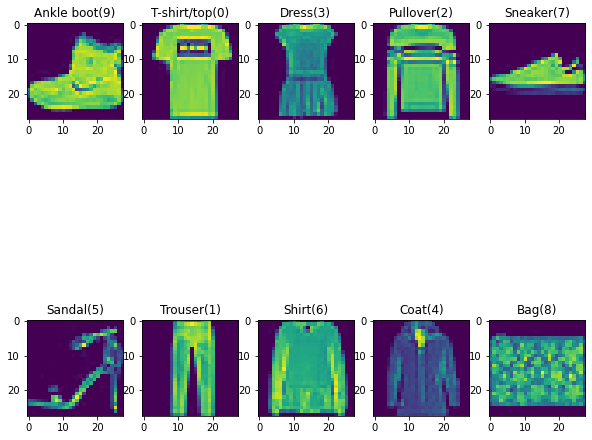

In [5]:
labels={0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}
plt.figure(figsize=(10,10))
cls=[]
counter=1
for  data in train_data:
    if data[1] not in cls:
        cls.append(data[1])
        plt.subplot(2,5,counter)
        plt.imshow(data[0])
        plt.title(labels[data[1]]+'('+str(data[1])+')')
        counter+=1
    if len(cls)==10:
        break

In [6]:
mean=train_data.data.float().mean()
std =train_data.data.float().std()
transform = transforms.Compose([
    transforms.ToTensor()]
    )
train_data.transform=transform
test_data.transform=transform
num_workers=2
batch_size=128
train_dataset,validaton_dataset=random_split(train_data,[50000,10000])

train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers)

validation_loader=torch.utils.data.DataLoader(validaton_dataset,batch_size=batch_size,num_workers=num_workers)

test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

# Network Implimentation

In [7]:

def Relu(tensor):
    x = torch.clone(tensor)
    x[x<0]=0
    return x
def Softmax(tensor):
  return torch.exp(tensor)/torch.sum(torch.exp(tensor),dim=1)[:,None]
def Accuracy(pred_y,true_class):
  return torch.sum(torch.argmax(pred_y,dim=1)==true_class)/len(true_class)

def CrossEntropy(pred_y,true_class):
  data_index=torch.tensor(list(range(len(true_class))))
  return torch.sum(-1*torch.log(pred_y[data_index,true_class]))

class FNet():
    def __init__(self,Lr=1e-4,wd=1e-3):
        self.Fc1   = (torch.randn((784,512))/(784**0.5)).cuda().requires_grad_()
        self.Bias1 = (torch.zeros((512))).cuda().requires_grad_()
        self.Fc2   = (torch.randn((512,256))/ 512**0.5 ).cuda().requires_grad_()
        self.Bias2 = (torch.zeros((256))).cuda().requires_grad_()
        self.Fc3   = (torch.randn((256,10))/ (256**0.5)).cuda().requires_grad_()
        self.Bias3 = (torch.zeros((10))).cuda().requires_grad_()
        
        self.wd=wd
        self.Lr=Lr
    def forward(self,input):

      x=Relu(input @ self.Fc1 + self.Bias1)
      x=Relu(x @ self.Fc2 + self.Bias2)
      x=Softmax(x @ self.Fc3 + self.Bias3)

      return x
    def Update_Weight(self):

      with torch.no_grad():
        self.Fc1  =(self.Fc1*(1-self.wd) -  self.Lr*self.Fc1.grad).requires_grad_()
        self.Bias1 = (self.Bias1*(1-self.wd) - self.Lr *self.Bias1.grad).requires_grad_()
        self.Fc2 = (self.Fc2*(1-self.wd) - self.Lr*self.Fc2.grad).requires_grad_()
        self.Bias2 = (self.Bias2*(1-self.wd) - self.Lr *self.Bias2.grad).requires_grad_()
        self.Fc3 = (self.Fc3*(1-self.wd) - self.Lr*self.Fc3.grad).requires_grad_()
        self.Bias3 = (self.Bias3*(1-self.wd) - self.Lr *self.Bias3.grad).requires_grad_()
      torch.cuda.empty_cache()
 

    def Train(self,X,Y):
      predicted_porb=self.forward(X)
      Loss_function=CrossEntropy(predicted_porb,Y)
      Loss_function.backward()
      self.Update_Weight()
      
      return predicted_porb,Loss_function
    def Test(self,x):
        predicted_porb=self.forward(X)
        Loss_function=CrossEntropy(predicted_porb,Y)
        return predicted_porb,Loss_function



# Training

In [9]:
epochs = 50
model=FNet(Lr=1e-3,wd=1e-5)
best_model=None
Acc_best=0.0
Loss_train=[]
Loss_test=[]
Acc_train=[]
Acc_test= []

for epoch in range(epochs):
  Acc=[]
  Loss=[]
  cnt = batch_size
  print(f"********************** Epoch {epoch} *************************")
  for x , y in train_loader:
    
    X = torch.autograd.Variable(x.reshape(-1,784).cuda())
    Y = y.cuda()
    predicted_porb,Loss_function=model.Train(X,Y)
    
    Loss.append(Loss_function.cpu().detach())
    Acc.append(Accuracy(predicted_porb.cpu().detach(),Y.cpu().detach()))
    
    # print(f"Accuary {Acc[-1]*100} %  Loss  {Loss_function}.............   {cnt}/ 60000")
    # cnt+=len(X)
  

  Loss_train.append(torch.mean(torch.tensor(Loss)))
  Acc_train.append(torch.mean(torch.tensor(Acc)))
  
  print(f"Train Loss is {Loss_train[-1]} , Train Accuracy is {Acc_train[-1]}")
  Acc=[]
  Loss=[]
  for x , y in validation_loader:
    X = torch.autograd.Variable(x.reshape(-1,784).cuda())
    Y = y.cuda()
    predicted_porb,Loss_function=model.Test(X)
    Loss.append(Loss_function.cpu().detach())
    Acc.append(Accuracy(predicted_porb.cpu().detach(),Y.cpu().detach()))

  Loss_test.append(torch.mean(torch.tensor(Loss)))
  Acc_test.append(torch.mean(torch.tensor(Acc)))
  if Acc_test[-1]>Acc_best:
    Acc_best=Acc_test[-1]
    best_model=model

  print(f"Validation Loss is {Loss_test[-1]} , Validation Accuracy is {Acc_test[-1]}")
  


********************** Epoch 0 *************************
Train Loss is 86.77241516113281 , Train Accuracy is 0.7629795670509338
Validation Loss is 61.352996826171875 , Validation Accuracy is 0.8285205960273743
********************** Epoch 1 *************************
Train Loss is 57.839500427246094 , Train Accuracy is 0.8389625549316406
Validation Loss is 52.80887222290039 , Validation Accuracy is 0.8495846390724182
********************** Epoch 2 *************************
Train Loss is 51.11135482788086 , Train Accuracy is 0.856377899646759
Validation Loss is 48.66960525512695 , Validation Accuracy is 0.859375
********************** Epoch 3 *************************
Train Loss is 47.03400802612305 , Train Accuracy is 0.8668118715286255
Validation Loss is 46.44740295410156 , Validation Accuracy is 0.8653085231781006
********************** Epoch 4 *************************
Train Loss is 44.07378005981445 , Train Accuracy is 0.8749639987945557
Validation Loss is 45.01836013793945 , Valida

In [22]:
Acc=[]
Loss=[]
pred_class=[]
true_class=[]
dataset=[]
for x , y in test_loader:
  X = torch.autograd.Variable(x.reshape(-1,784).cuda())
  Y = y.cuda()  
  predicted_porb,Loss_function=best_model.Test(X)
  Loss.append(Loss_function.cpu().detach())
  Acc.append(Accuracy(predicted_porb.cpu().detach(),Y.cpu().detach()))
  pred_class.extend(torch.argmax(predicted_porb.cpu(),dim=1))
  true_class.extend(Y.cpu().detach())
  dataset.extend(X.cpu().detach())
Loss_test.append(torch.mean(torch.tensor(Loss)))
Acc_test.append(torch.mean(torch.tensor(Acc)))
print(f"Test Loss is {Loss_test[-1]} , Test Accuracy is {Acc_test[-1]}")

Test Loss is 51.82836151123047 , Test Accuracy is 0.8890427350997925


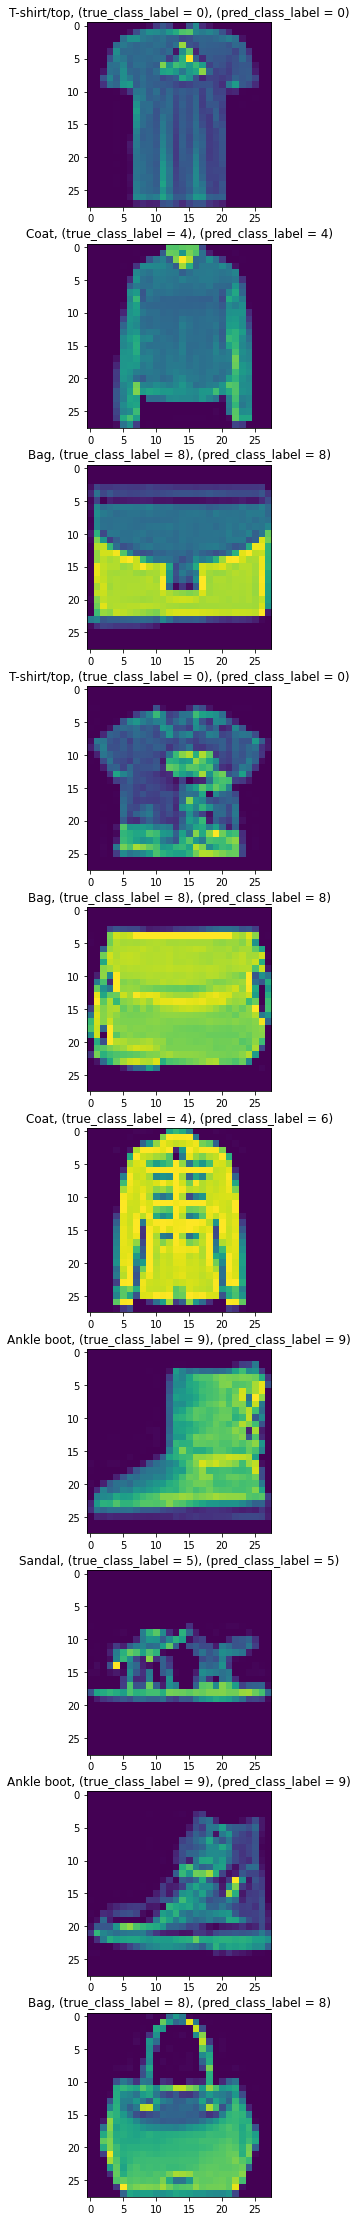

In [34]:
import random
rand_int=random.sample(range(0, 1000), 10)
labels={0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}
plt.figure(figsize=(20,40))

counter=1
for  idx in rand_int:
  cls.append(data[1])
  plt.subplot(10,1,counter)
  plt.imshow(dataset[idx].reshape(28,28))
  plt.title(label=f"{labels[int(true_class[idx])]}, (true_class_label = {true_class[idx]}), (pred_class_label = {pred_class[idx]})")
  counter+=1
  

# Debug

In [ ]:
#test
def forward(input):
  Lr=1e-3
  Fc1   = (torch.randn((784,512))*0.001).cuda().requires_grad_()
  Bias1 = (torch.randn((512))*0.001).cuda().requires_grad_()
  Fc2   = (torch.randn((512,256))/ (512**0.5)).cuda().requires_grad_()
  Bias2 = (torch.randn((256))/ (512**0.5)).cuda().requires_grad_()
  Fc3   = (torch.randn((256,10))/ (512**0.5)).cuda().requires_grad_()
  Bias3 = (torch.randn((10))/(512**0.5)).cuda().requires_grad_()
  

  for i in range(2000):

    
    x=Relu(input @ Fc1 + Bias1)
    # x1[x1<0]=0

    x=Relu(x @ Fc2 + Bias2)
    # x2[x2<0]=0

    x=Softmax(x @ Fc3 + Bias3)
    # x4=torch.exp(x3)/torch.sum(torch.exp(x3),dim=1)[:,None]
    data_index=torch.tensor(list(range(16)))
    Loss_function=torch.sum(-1*torch.log(x[data_index,torch.tensor([0,1,2,5,3,5,8,9,7,1,4,8,9,1,2,3])]))
    # x4=torch.exp(x3)/torch.sum(torch.exp(x3),dim=1)[:,None]
    # print('Fc1',Fc1.requires_grad)
    # print('Fc2',Fc2.requires_grad)
    # print('Fc3',Fc3.requires_grad)

    Loss_function.backward()



    print(Loss_function)
    # print(Bias3)
    with torch.no_grad():
      Fc1  =(Fc1 -  Lr*Fc1).requires_grad_()
      Bias1 = (Bias1 - Lr *Bias1.grad).requires_grad_()
      Fc2 = (Fc2 - Lr*Fc2.grad).requires_grad_()
      Bias2 = (Bias2 - Lr *Bias2.grad).requires_grad_()
      Fc3 = (Fc3 - Lr*Fc3.grad).requires_grad_()
      Bias3 = (Bias3 - Lr *Bias3.grad).requires_grad_()   
    torch.cuda.empty_cache()



x=torch.randn(size=(16,784),device='cuda:0')
forward(x)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
class MLP_net(nn.Module):
  def __init__(self):
    super(MLP_net,self).__init__()
    self.fc1=nn.Linear(784,512)
    self.fc2=nn.Linear(512,256)
    self.out=nn.Linear(256,10)
      
    # Dropout probability - set for avoiding overfitting
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
      x = x.view(-1, 28 * 28)        
      x=self.dropout(F.relu(self.fc1(x)))
      x=self.dropout(F.relu(self.fc2(x)))
      x=self.out(x)
      return x
def Acc(pred_y,true_class):
  return torch.sum(torch.argmax(pred_y,dim=1)==true_class)/len(true_class)
model_1=MLP_net()

def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
model_1.apply(weight_init_normal)
model=model_1.cuda()   
    # return torch.sum(torch.where(true_labels==1)[1] == torch.where(output==1)[1]) / len(output)

lr=1e-3
Epochs=100
optim='Adam'

criterion=nn.CrossEntropyLoss()
if optim=='Adam':
    optimizer=torch.optim.Adam(model.parameters(),lr=lr,weight_decay=0)
elif optim=='SGD' :
    print('SGD')
    optimizer=torch.optim.SGD(model.parameters(),nesterov=True,momentum=0.9,weight_decay=1e-3,lr=lr)
Train_Acc_array=[]
validation_Acc_array=[]
for i in range(Epochs):
  # ****************** Training *******************
  model.train()
  Loss_train=[]
  Acc_train=[]
  print(f'###################### Epoch {i} #####################')
  for data,label in train_loader:
    data,label=data.cuda(),label.cuda()
    optimizer.zero_grad()
    output=model(data)
    Loss=criterion(output,label)
    Loss.backward()
    optimizer.step()
    Loss_train.append(Loss)
    Acc_train.append(Acc(output,label))
  Train_Acc_array.append(torch.mean(torch.tensor(Acc_train)))
  print(f'Train Cross Entropy Loss {torch.mean(torch.tensor(Loss_train))}')
  print(f'Train Accuracy is {Train_Acc_array[-1]*100}')
  # ****************** Test  *******************
  model.eval()
  Loss_test=[]
  Acc_test=[]
  for data,label in test_loader:
    data,label=data.cuda(),label.cuda()
    output=model(data)
    Loss=criterion(output,label)
    Loss_test.append(Loss)
    Acc_test.append(Acc(output,label))
    
  validation_Acc_array.append(torch.mean(torch.tensor(Acc_test)))
  print(f'Test Cross Entropy Loss {torch.mean(torch.tensor(Loss_test))}')
  print(f'Test Accuracy is {validation_Acc_array[-1]*100}')
  print('#######################################################')

